In [7]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import skopt.plots
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Integer, Categorical
from skopt.utils import use_named_args
import os
import logging
import importlib
import EarlyStopPytorch
importlib.reload(EarlyStopPytorch)
from EarlyStopPytorch import EarlyStopping
import shap

In [6]:
torch.__version__

'2.0.0+cpu'

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [5]:
# print(torch.cuda.get_device_name(0))

In [8]:
df = pd.read_csv("bottomhole_pressure.txt", sep = " ")
# Remove irrelevant vairables 
df = df.drop(['S.N', 'wh'], axis=1)
# Rename the variables
df  = df.rename(columns={'MBHP': "FBHP", 'QO': "Oil_rate", 'Qg': "Gas_rate", 'QW': "Water_rate", 'TBG': "Tubing_ID",
                   'API': "Oil_gravity", 'P': "Pwh"})

In [9]:
# Avoid adding duplicated dummy variables from Tubing_ID
if sum([col.startswith('Tubing') for col in df.columns]) == 1:
    # create dummy variable for Tubing_ID
    tubing_dummy_vars = pd.get_dummies(df['Tubing_ID'], prefix='Tubing_Id').astype(int)
    df = pd.concat([df, tubing_dummy_vars], axis=1)
    # remove the last dummy variable
    df = df.drop(['Tubing_ID','Tubing_Id_4.0'], axis=1)
# Number of predictors 
n_features = len(df.columns[1:])
print(f'There are {n_features} features')

There are 13 features


In [ ]:
# class FFNN(nn.Module):
#     def __init__(self, input_size, n_layers, neurons, activations):
#         super(FFNN, self).__init__()
#         self.input_size = int(input_size)
#         self.n_layers =int(n_layers)
#         self.neurons = [int(neuron) for neuron in neurons]
#         self.activations = [str(activation) for activation in activations]     

#         # Define the first hidden layer with activation
#         self.hidden_layers = nn.ModuleList()

#         self.actions = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}      
    
#         for i in range(self.n_layers):
#             in_features = self.input_size if i == 0 else self.neurons[i-1]
#             out_features = self.neurons[i]
#             activation = self.get_activation(self.activations[i])
#             self.hidden_layers.append(nn.Sequential(
#                 nn.Linear(in_features, out_features),
#                 activation
#             ))

#         # Define the output layer
#         self.output_layer = nn.Linear(neurons[-1], 1)

#     def get_activation(self, activation):
#         action = self.actions.get(activation, None)
#         if action is None:
#             raise ValueError("Invalid activation function: {}".format(activation))
#         return action

#     def forward(self, x):
#         out = x
#         # Feed input through first hidden layer
#         for i in range(self.n_layers):
#             out = self.hidden_layers[i](out)
#         # Feed output of final hidden layer through output layer
#         out = self.output_layer(out)
#         return out


In [23]:
# FIX "RuntimeError: The size of tensor a (100) must match the size of tensor b (10) at non-singleton dimension 1" 
#in previous architecture acr by using nn.Sequential()

class FFNN(nn.Module):
    def __init__(self, input_size, n_layers, neurons, activations):
        super(FFNN, self).__init__()
        self.input_size = int(input_size)
        self.n_layers = int(n_layers)
        self.neurons = [int(neuron) for neuron in neurons]
        self.activations = [str(activation) for activation in activations]

        # Define the hidden layers with activations
        self.hidden_layers = nn.Sequential()
        in_features = self.input_size
        for i in range(self.n_layers):
            out_features = self.neurons[i]
            activation = self.get_activation(self.activations[i])
            self.hidden_layers.add_module(f"linear_{i}", nn.Linear(in_features, out_features))
            self.hidden_layers.add_module(f"activation_{i}", activation)
            in_features = out_features

        # Define the output layer
        self.output_layer = nn.Linear(self.neurons[-1], 1)

    def get_activation(self, activation):
        actions = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
        action = actions.get(activation, None)
        if action is None:
            raise ValueError("Invalid activation function: {}".format(activation))
        return action

    def forward(self, x):
        out = self.hidden_layers(x)
        out = self.output_layer(out)
        return out


In [24]:
def select_optimizer(optimizer, model):
    # Define the optimizer
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    elif optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
    elif optimizer == 'adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0001)
        
    elif optimizer == 'adamax':
        optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)
    elif optimizer == 'asgd':
        optimizer = torch.optim.ASGD(model.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    
    return optimizer

In [25]:
def cross_validate(train_cv, train_idx, val_idx, batch_size):
    
    train_fold = train_cv.iloc[train_idx]
    val_fold = train_cv.iloc[val_idx]

    # Scale the data
    scaler_X = MinMaxScaler()
    train_X_scaled = scaler_X.fit_transform(train_fold.iloc[:, 1:])
    val_X_scaled = scaler_X.transform(val_fold.iloc[:, 1:])

    scaler_y = MinMaxScaler()
    train_y_scaled = scaler_y.fit_transform(train_fold.iloc[:, 0:1])
    val_y_scaled = scaler_y.transform(val_fold.iloc[:, 0:1])

    # Convert to PyTorch Tensors
    train_X_tensor = torch.tensor(train_X_scaled).float()
    val_X_tensor = torch.tensor(val_X_scaled).float()
    train_y_tensor = torch.tensor(train_y_scaled).float()
    val_y_tensor = torch.tensor(val_y_scaled).float()

    # Create DataLoaders for the datasets
    train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [26]:
def train_model(train_loader, model, criterion, optimizer):

    train_loss = 0
    for _, (data, target) in enumerate(train_loader):
        #Pass the data to the GPU/CPU
        data = data.to(device)
        target = target.to(device)
        # Forward pass 
        y_pred = model(data)

        # Compute the loss
        loss = criterion(y_pred, target)

        # Backward pass and optimization
        # zero out the gradients of all parameters before calling loss.backward()
        optimizer.zero_grad()
        # Compute the gradients with respect to the loss
        loss.backward()
        # update the parameters based on the gradients
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Compute the average training loss for the epoch
    train_loss /= len(train_loader)
    

    return train_loss

In [27]:
def evaluate_model(val_loader, model, criterion):
    # Compute the validation loss for the epoch
    val_loss = 0
    # temporarily disable gradient computation to save memory and speed up computations 
    # because we don't need to compute gradients for validation 
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            # Forward pass
            y_pred = model(data)

            # Compute the loss
            loss = criterion(y_pred, target)

            # Accumulate the validation loss
            val_loss += loss.item()

    # Compute the average validation loss for the epoch
    val_loss /= len(val_loader)
    
    
    return val_loss

In [13]:
# Log the training results to std.log file
if os.path.exists('std.log'):
    os.remove('std.log')
for handler in logging.root.handlers:
    logging.root.removeHandler(handler)
# Configure the logging to write only to std.log file and overwrite its contents
logging.basicConfig(filename='std.log', level=logging.INFO, format='%(asctime)s %(message)s', filemode='w')

# Define the search space for hyperparameters
search_space = [
    Integer(1, 3, name='n_layers'),
    # Use a loop to generate the number of neurons and activations
    *[Integer(10, 100, name=f'neurons_{i}') for i in range(3)],
    *[Categorical(['relu', 'tanh', 'sigmoid'], name=f'activations_{i}') for i in range(3)],

    Categorical(['adam',  'rmsprop', 'adagrad', 'adadelta', 'adamax', 'asgd' ], name='optimizer'),
    Integer(2, 32, name='batch_size')
]


# Initialize the count variable
combination_count = 0

scores_dict = {}
# Define the objective function as an MLflow function
@use_named_args(search_space)
def objective(**params):

    input_size = 13
    # Extract the hyperparameters
    n_layers = int(params['n_layers'])
    neurons = [params[f'neurons_{i}'] for i in range(n_layers)]
    activations = [params[f'activations_{i}'] for i in range(n_layers)]
    optimizer = params['optimizer']
    batch_size = int(params['batch_size'])
    n_epochs = 400
    
    #seed the RNG for all devices (both CPU and CUDA)
    torch.manual_seed(0)
    np.random.seed(0)
    
    # Print the hyperparameters
    print(f"n_layers={n_layers}, neurons={neurons}, activations={activations}, optimizer={optimizer}, batch_size={batch_size}")
    # Access the count variable
    global combination_count
    combination_count += 1
    print(f"Combination: {combination_count}")
    logging.info("Combination: %s", combination_count)

    # Create an instance of the model
    model = FFNN(input_size, n_layers, neurons, activations).to(device)



    print(model)
    logging.info(model)

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = select_optimizer(optimizer, model)

    
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=False)

    Hyperparameters = {
        "Combination ":combination_count,
        "n_layers ":n_layers, 
        "neurons ":neurons, 
        "activations ":activations, 
        "optimizer ":optimizer.__class__.__name__,
        "batch_size ":batch_size
                    }
    logging.info("Hyperparameters: %s", Hyperparameters)
    # Log the search space
    # mlflow.log_texr({param.name: search_space[i].get_hyperparameters()[0].__repr__() for i, param in enumerate(search_space)})
    folds_val_losses = []
    # split data into 80% training and 20% test sets
    train_cv, _ = train_test_split(df, test_size=0.2, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_cv)):
        logging.info("Fold: %s", fold+1)
        train_loader, val_loader = cross_validate(train_cv, train_idx, val_idx, batch_size)
        
        early_stopping = EarlyStopping(patience=50, 
                                mode='min',
                                verbose =True, 
                                restore_best_weights=True)

        val_losses = []

        for epoch in range(1, n_epochs+1):
            # Train the model on the training set
            epoch_train_loss = train_model(train_loader, model, criterion, optimizer)
            # Evaluate the model on the validation set
            epoch_val_loss = evaluate_model(val_loader, model, criterion)
            val_losses.append(epoch_val_loss)

            # Print the training and validation losses for the epoch
            logging.info("Epoch %s - Train Loss: %.5f, Val Loss: %.5f", epoch, epoch_train_loss, epoch_val_loss )

            early_stopping(model, epoch, epoch_val_loss)
            if early_stopping.early_stop:
                logging.info("Stopping early!")
                logging.info(" Best epoch: %s,  Val Loss: %s", 
                    early_stopping.best_epoch, early_stopping.best_score)
                epoch_val_loss = early_stopping.best_score
                break 

        folds_val_losses.append(epoch_val_loss)


    mean_mse = np.mean(folds_val_losses)
    print("Mean Validation MSE Loss Across All Folds: ", mean_mse)
    std_mse = np.std(folds_val_losses)
    print("Standard deviation of MSE Loss: ", std_mse)

    
    logging.info("Mean Validation MSE Loss Across All Folds: %s", mean_mse)
    logging.info("Standard deviation of MSE Loss : %s", std_mse)


    # Store the scores for this hyperparameter combination in the dictionary
    scores_dict[str(Hyperparameters)] = folds_val_losses

    # Return the validation loss --> argmin f(x)
    # where f(x) is the objective function (np.mean(folds_val_losses)) and
    # argmin denotes the argument (Hyperparameters) that minimizes the function
    # return np.mean(folds_val_losses)
    return np.mean(folds_val_losses)



# Run Bayesian optimization to find the best hyperparameters
#n_calls -> the number of hyperparamters combinations the optimizer will generate
#n_random_starts -> the number of random initialization points the optimizer should make to 
#update its beliefs and take the best directions that minimizes the loss function
result = gp_minimize(objective, search_space, n_calls=500, n_random_starts=30, random_state=42)

# Print the best hyperparameters and their corresponding mean and standard deviation
best_hyperparams = None
best_mean_score = float('inf')
for hyperparams, scores in scores_dict.items():
    mean_score = np.mean([score for score in scores])
    std_score = np.std([score for score in scores])
    if mean_score < best_mean_score:
        best_hyperparams = hyperparams
        best_mean_score = mean_score
        best_std_score = std_score
        
logging.info("\nBest hyperparameters: %s", best_hyperparams)
logging.info("Mean MSE Loss for validation set in all folds: %s", best_mean_score)
logging.info("Standard deviation for MSE Loss: %s", best_std_score)
print("\nBest hyperparameters: ", best_hyperparams)
print("Mean MSE Loss for validation set in all folds (Best hyperparameters): ", best_mean_score)
print("Standard deviation for MSE Loss (Best hyperparameters): ", best_std_score)

logging.shutdown()

n_layers=3, neurons=[27, 80, 64], activations=['sigmoid', 'relu', 'sigmoid'], optimizer=adam, batch_size=6
Combination: 1
FFNN(
  (hidden_layers): Sequential(
    (linear_0): Linear(in_features=13, out_features=27, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=27, out_features=80, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=80, out_features=64, bias=True)
    (activation_2): Sigmoid()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
EarlyStopping-> best epoch: 87, best score: 0.0046342624312577145
EarlyStopping-> best epoch: 4, best score: 0.0027082283825924
EarlyStopping-> best epoch: 36, best score: 0.03227889467962086
Mean Validation MSE Loss Across All Folds:  0.009539608066552319
Standard deviation of MSE Loss:  0.011413695751896583
n_layers=1, neurons=[100], activations=['tanh'], optimizer=rmsprop, batch_size=32
Combination: 2
FFNN(
  (hidden_layers): Sequential(
    (linear_0): Linear(in_features

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

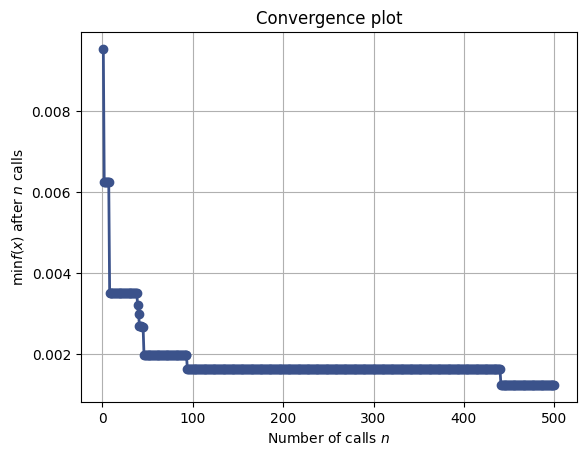

In [16]:
skopt.plots.plot_convergence(result)

In [21]:
# Convert the scores dictionary to a DataFrame
optimization_scores = pd.DataFrame.from_dict(scores_dict, orient='index')

# Extract the combination number from the dictionary key
optimization_scores['Combination'] = optimization_scores.index.str.extract("'Combination ': (\d+)").astype(int)

# Calculate the mean and standard deviation for each combination
optimization_scores['Mean MSE'] = optimization_scores.apply(lambda row: row[:-1].mean(), axis=1)
optimization_scores['Std'] =optimization_scores.apply(lambda row: row[:-1].std(), axis=1)

# Reorder the columns
optimization_scores = optimization_scores[['Combination', 'Mean MSE', 'Std']]

# sort df by MSE 
optimization_scores.sort_values(by='Mean MSE').head(10)

,Combination,Mean MSE,Std
"{'Combination ': 441, 'n_layers ': 3, 'neurons ': [100, 100, 62], 'activations ': ['relu', 'relu', 'sigmoid'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.001242,0.000987
"{'Combination ': 497, 'n_layers ': 3, 'neurons ': [100, 100, 98], 'activations ': ['relu', 'tanh', 'relu'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.001281,0.001022
"{'Combination ': 484, 'n_layers ': 3, 'neurons ': [95, 99, 100], 'activations ': ['relu', 'tanh', 'relu'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.001414,0.001487
"{'Combination ': 94, 'n_layers ': 3, 'neurons ': [100, 100, 10], 'activations ': ['relu', 'tanh', 'tanh'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.001633,0.001150
"{'Combination ': 381, 'n_layers ': 3, 'neurons ': [10, 100, 42], 'activations ': ['relu', 'relu', 'relu'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.001792,0.001669
"{'Combination ': 46, 'n_layers ': 3, 'neurons ': [100, 46, 10], 'activations ': ['relu', 'relu', 'tanh'], 'optimizer ': 'RMSprop', 'batch_size ': 2}",NaN,0.001990,0.001422
"{'Combination ': 344, 'n_layers ': 3, 'neurons ': [10, 100, 97], 'activations ': ['relu', 'relu', 'relu'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.002012,0.001199
"{'Combination ': 457, 'n_layers ': 3, 'neurons ': [100, 50, 73], 'activations ': ['relu', 'relu', 'tanh'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.002047,0.001261
"{'Combination ': 435, 'n_layers ': 3, 'neurons ': [100, 31, 54], 'activations ': ['relu', 'tanh', 'tanh'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.002085,0.000890
"{'Combination ': 447, 'n_layers ': 3, 'neurons ': [10, 82, 50], 'activations ': ['relu', 'relu', 'relu'], 'optimizer ': 'Adam', 'batch_size ': 2}",NaN,0.002112,0.001588


# Train model with the optimal hyperparameters

In [28]:
# split data into 80% training and 20% test sets
train_X, test_X, train_y, test_y = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.2, random_state=42)


# scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
train_X_scaled = scaler_X.fit_transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = MinMaxScaler()
train_y_scaled = scaler_y.fit_transform(train_y)
test_y_scaled = scaler_y.transform(test_y)


# Convert the numpy arrays to PyTorch tensors
train_X_tensor = torch.tensor(train_X_scaled, dtype=torch.float32)
# save train_X_tensor to use later as a background sample for the shapley values
torch.save(train_X_tensor, 'train_X_tensor.pt')
test_X_tensor = torch.tensor(test_X_scaled, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_scaled, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_scaled, dtype=torch.float32)

# print the shapes
print("train_X_tensor shape: ", train_X_tensor.shape)
print("test_X_tensor shape: ", test_X_tensor.shape)
print("train_y_tensor shape: ", train_y_tensor.shape)
print("test_y_tensor shape: ", test_y_tensor.shape)


train_X_tensor shape:  torch.Size([164, 13])
test_X_tensor shape:  torch.Size([42, 13])
train_y_tensor shape:  torch.Size([164, 1])
test_y_tensor shape:  torch.Size([42, 1])


In [31]:
import time

start_time = time.time()

#seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
np.random.seed(0)

input_size = 13
n_layers = 3
neurons = [100, 100, 62]
activations = ['relu', 'relu', 'sigmoid']
optimizer = 'adam'
batch_size = 2
n_epochs = 400
# Create an instance of the model and pass the network to the GPU
model = FFNN(input_size, n_layers, neurons, activations).to(device)



# Define the loss function
criterion = nn.MSELoss()
    

 # Define the optimizer
optimizer = select_optimizer(optimizer, model)

early_stopping = EarlyStopping(patience=50, 
                                mode='min', 
                                verbose=True,
                                restore_best_weights=True)

# Create data loaders for training and testing sets
train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X_tensor, test_y_tensor), batch_size=batch_size, shuffle=False)

test_losses = []
# best_weights = None
#Epochs
for epoch in range(1, n_epochs+1):
    # Train the model on the training set
    epoch_train_loss = train_model(train_loader, model, criterion, optimizer)
    # Evaluate the model on the testing set
    with torch.no_grad():
        epoch_test_loss = 0
        # Put model in evaluation mode
        model.eval()
        #Batches
        for data, target in test_loader:
            #Pass the data to the GPU/CPU
            data = data.to(device)
            target = target.to(device)
            # Forward pass
            output = model(data)
            epoch_test_loss += criterion(output, target).item()
            
        epoch_test_loss /= len(test_loader)
    # Print the training and validation losses for the epoch
    print("Epoch %s - Train Loss: %.5f, Test Loss: %.5f" % (epoch, epoch_train_loss, epoch_test_loss))
    # Track testing loss wit earlystopping strategy
    early_stopping(model, epoch, epoch_test_loss)
    if early_stopping.early_stop:
        break

end_time = time.time()

total_time = end_time - start_time
print(f"Total running time with {device.type} : {total_time:.2f} seconds")

Epoch 1 - Train Loss: 0.02373, Test Loss: 0.01989
Epoch 2 - Train Loss: 0.02223, Test Loss: 0.01831
Epoch 3 - Train Loss: 0.02115, Test Loss: 0.01715
Epoch 4 - Train Loss: 0.01952, Test Loss: 0.01543
Epoch 5 - Train Loss: 0.01779, Test Loss: 0.01495
Epoch 6 - Train Loss: 0.01627, Test Loss: 0.01217
Epoch 7 - Train Loss: 0.01471, Test Loss: 0.01088
Epoch 8 - Train Loss: 0.01378, Test Loss: 0.01017
Epoch 9 - Train Loss: 0.01281, Test Loss: 0.00936
Epoch 10 - Train Loss: 0.01210, Test Loss: 0.00929
Epoch 11 - Train Loss: 0.01165, Test Loss: 0.00864
Epoch 12 - Train Loss: 0.01087, Test Loss: 0.00915
Epoch 13 - Train Loss: 0.01052, Test Loss: 0.00902
Epoch 14 - Train Loss: 0.01006, Test Loss: 0.00845
Epoch 15 - Train Loss: 0.00992, Test Loss: 0.00818
Epoch 16 - Train Loss: 0.00926, Test Loss: 0.00838
Epoch 17 - Train Loss: 0.00884, Test Loss: 0.00769
Epoch 18 - Train Loss: 0.00857, Test Loss: 0.00654
Epoch 19 - Train Loss: 0.00827, Test Loss: 0.00768
Epoch 20 - Train Loss: 0.00774, Test Los

# Run predictions for the optimized model

In [32]:
# move test_X_tensor input to device
data = test_X_tensor.to(device)
# Forward pass
with torch.no_grad():
      output = model(data)
      # remove from computational graph to cpu and as numpy
      y_pred =  output.cpu().numpy()

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Unscale the predictions
y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1,1))


# Calculate r-squared
r2 = r2_score(test_y.values, y_pred_unscaled)

# Calculate MAE
mae = mean_absolute_error(test_y.values, y_pred_unscaled)

# Calculate RMSE
rmse = mean_squared_error(test_y.values, y_pred_unscaled, squared=False)

# Print the metrics
print('Test R-squared:', r2)
print('Test MAE:', mae)
print('Test RMSE:', rmse)

Test R-squared: 0.9444481988346125
Test MAE: 47.08076695033482
Test RMSE: 66.6800845728371


# Save optimal model and scaler for predictors and target 

In [34]:
# save scalers and model
import pickle
# save scalers to file
with open('scaler_X.pickle', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pickle', 'wb') as f:
    pickle.dump(scaler_y, f)

# save the model
torch.save(model.state_dict(), "FFNNmodel.pth")

# Check if model saved properly

In [35]:
input_size = 13
n_layers = 3
neurons = [100, 100, 62]
activations = ['relu', 'relu', 'sigmoid']

model_test = FFNN(input_size, n_layers, neurons, activations)
model_test.load_state_dict(torch.load('FFNNmodel.pth'))
model_test = model_test.to(device)
# enabling the eval mode 
model_test.eval()
# move test_X_tensor input to device
data = test_X_tensor.to(device)
# Forward pass
with torch.no_grad():
      output = model_test(data)
      # remove from computational graph to cpu and as numpy
      y_pred_test =  output.cpu().numpy()

# Check if all the values in the y_pred_test array are equal to the corresponding values in the y_pred array
assert all(np.equal(y_pred_test, y_pred)), "Arrays are not equal"

# SHAP

In [36]:
# torch.set_grad_enabled(True)    
import shap
# Create the DeepExplainer object using the model and the training data tensor
explainer = shap.DeepExplainer(model, train_X_tensor)

# Compute the SHAP values for the test data tensor using the explainer object 
shap_values = explainer.shap_values(test_X_tensor)          
            
# inversed base value (average model's predictions)
ex = scaler_y.inverse_transform(explainer.expected_value[0].reshape(-1, 1))[0][0]

# inversed predicted values 
fx = scaler_y.inverse_transform(y_pred.reshape(-1,1))


# difference between the base value (expected value or average model's predictions) and instance actual prediction
contribution = fx-ex


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [37]:
# torch.set_grad_enabled(True)             
# inversed shap values
inversed_shap_values  = []
for i in range(test_y_tensor.shape[0]):
    result = (shap_values[i]/(shap_values[i]).sum())* contribution[i]
    inversed_shap_values.append(result)
# convert to 2d array
inversed_shap_values = np.array(inversed_shap_values)
# difference between the base value and instance actual prediction
ex = scaler_y.inverse_transform(explainer.expected_value[0].reshape(-1, 1))[0][0]

# Remove (-) from the features' names
features_names = test_X.columns.str.replace('_', ' ')


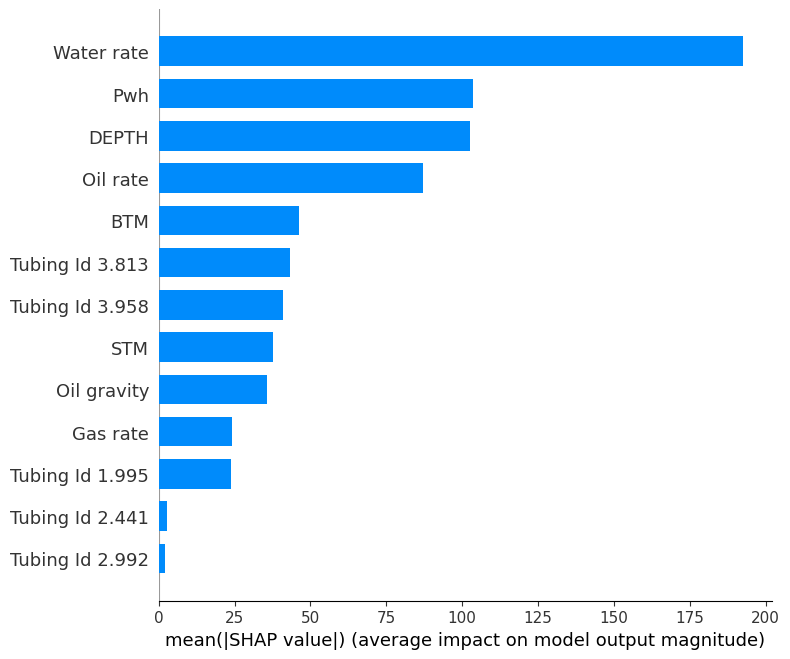

In [38]:
# Plot the SHAP summary plot for the test data (SHAP Global Interpretation)
shap.summary_plot(inversed_shap_values, test_X, feature_names=features_names, plot_type='bar')

In [39]:
# visualize all the training set predictions
shap.initjs()
shap.plots.force(ex, inversed_shap_values, feature_names = features_names, features=test_X.values)

In [40]:
class ShapInput(object):
    def __init__(self, 
                 inversed_base_value,
                 inversed_shap_values, 
                 inversed_features_values, 
                 feature_names):
        
            self.base_values = inversed_base_value
            self.values = inversed_shap_values
            self.display_data  = inversed_features_values
            self.feature_names = feature_names 


idx= 0
shap_input = ShapInput(ex, inversed_shap_values[idx], 
                       test_X.values[idx], features_names)


In [41]:
idx= 0
shap_input = ShapInput(ex, inversed_shap_values[idx], 
                       test_X.values[idx], features_names)

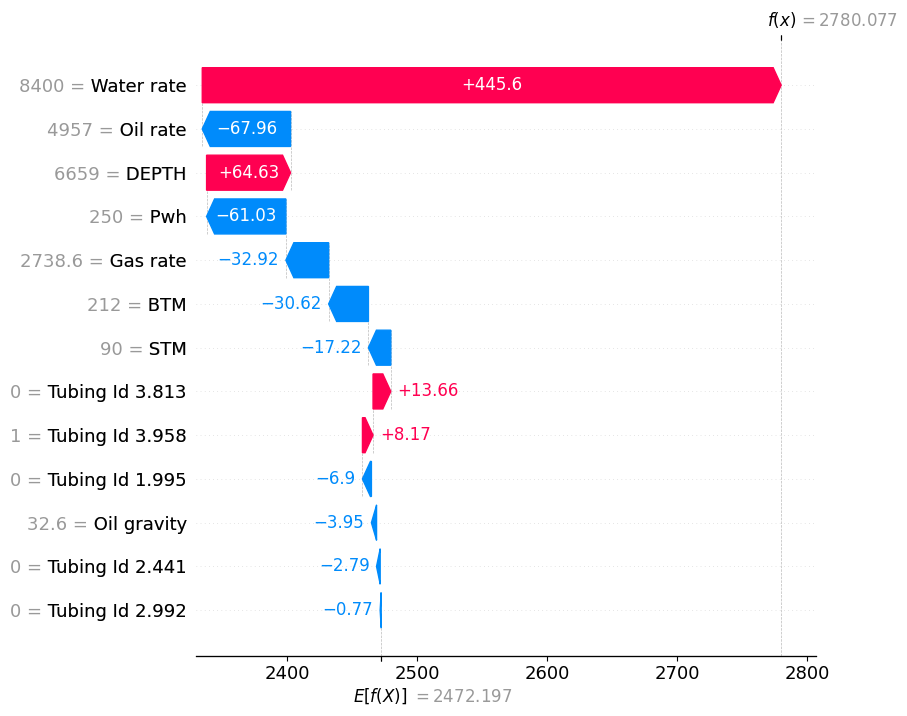

In [42]:
# SHAP Local Interpretation
shap.plots.waterfall(shap_input, max_display=13)

In [43]:
shap.initjs()
shap.plots.force(ex, inversed_shap_values[idx], feature_names = features_names, features=test_X.values[idx])

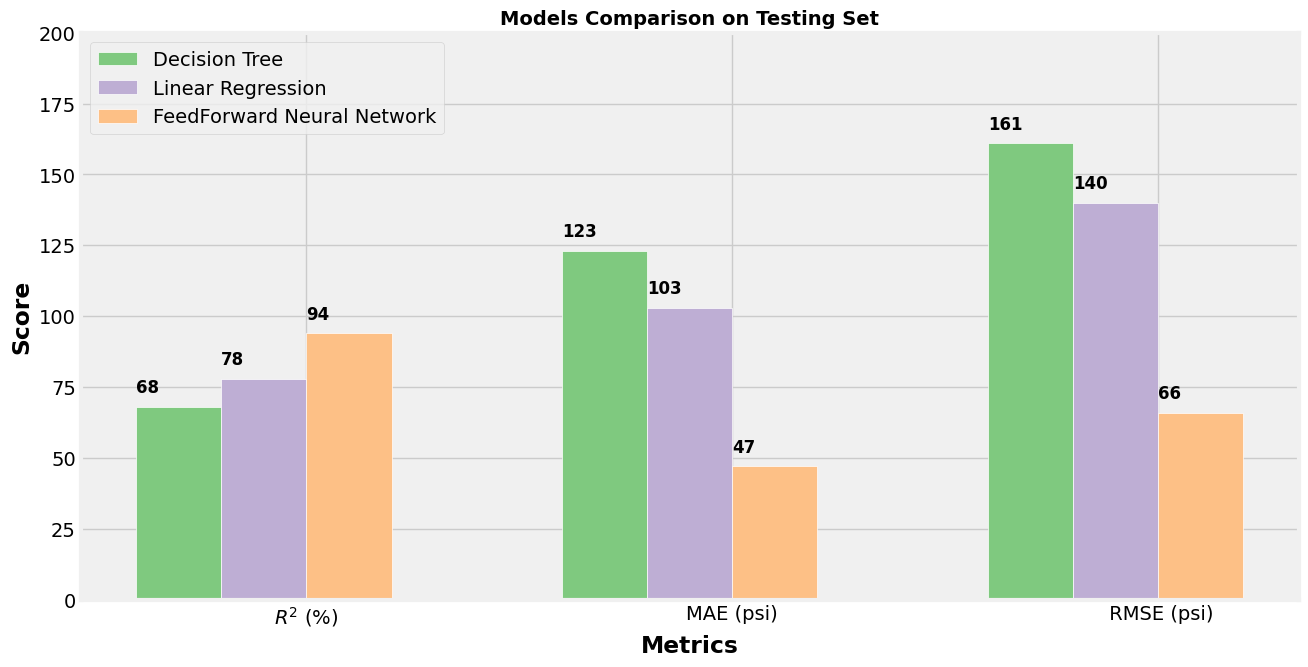

In [45]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

# Initialize figure with one plot
fig, ax1 = plt.subplots(1, 1)
# fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_size_inches(14, 7)
fig.set_facecolor('white')


# Set bar size
barWidth = 0.2
dt_score = [68, 123, 161]
lr_score = [78, 103, 140]
nn_score = [94, 47, 66]

# Set position of bars on X axis
r1 = np.arange(len(lr_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax1.bar(r1, dt_score, width=barWidth, edgecolor='white', label='Decision Tree', color="#7fc97f")
ax1.bar(r2, lr_score, width=barWidth, edgecolor='white', label='Linear Regression', color="#beaed4")
ax1.bar(r3, nn_score, width=barWidth, edgecolor='white', label='FeedForward Neural Network', color="#fdc086")

# Add scores to the top of each bar
for i, v in enumerate(dt_score):
    ax1.text(i - 0.1, v + 5, str(v), color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(lr_score):
    ax1.text(i + barWidth - 0.1, v + 5, str(v), color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(nn_score):
    ax1.text(i + 2*barWidth - 0.1, v + 5, str(v), color='black', fontweight='bold', fontsize=12)

# Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')


labels = [r'$R^2$ (%)', 'MAE (psi)', ' RMSE (psi)']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(lr_score))])
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 200)

# Create legend & title
ax1.set_title('Models Comparison on Testing Set', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')

# Display the plot
plt.show()
